# ZILLOW HOUSING DATA TIME SERIES ANALYSIS

## BUSINESS UNDERSTANDING 

### PROBLEM STATEMENT

Real investment firms weigh on many factors when deciding on which investment to make. These firms’ goals are to enhance their decision making processes. With historical real estate market data, the challenge is to leverage data science techniques to identify potential investment opportunities and helping the real estate firms in making informed investment decisions.

### OBJECTIVES
Main Objectives:
* Identify the 5 best zip codes.

Secondary Objectives:
* Predict the prices of the best 5 zipcodes. 

In [202]:
!pip install prophet

!pip install pmdarima


In [203]:
## Importing the necessary Libraries
import pandas as pd
import matplotlib.pyplot as plt
from functions import *  
import numpy as np
import seaborn as sns
from scipy.stats import boxcox
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from matplotlib.pylab import rcParams
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima
from statsmodels.tsa.holtwinters import ExponentialSmoothing



import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")


## DATA UNDERSTANDING

#### Load the dataset

This project uses data from ZIllow housing data,  found [here](https://www.zillow.com/research/data/)

In [204]:
data = pd.read_csv("data/zillow_data.csv")
data.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [205]:
len(data["RegionName"].unique())

14723

In [206]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14723 entries, 0 to 14722
Columns: 272 entries, RegionID to 2018-04
dtypes: float64(219), int64(49), object(4)
memory usage: 30.6+ MB


The dataset contains 14723 rows and 272 columns.    
Each of the row is a unique zipcode.    
The dataset as seen is in a Wide format. Columns 1-7 show the different properties of a house.    
However,  column 8 to column 272 are actual time series values. The columns refer to the median house sales values for their respective month and year.      
This format makes the dataframe intuitive and easy to read. However problems with this dataset may come in when it comes to actually learning from the data. We'll deal with that when we get there.   
The first 7 columns represent:
* RegionID - The Regional ID for the region where a house is located.
* RegionName - The Zipcode. 
* City - The City of a particular house. 
* State - The state in which a home is in. 
* Metro - The metropolitan area where the home is found. 
* CountyName - The county where the home is in. 
* SizeRank - Hapa sijui. 

Drop the unnecessary columns and rename the RegionName to zipcode

In [207]:
#  drop the unnecessary columns
data.drop(["RegionID", "Metro", "SizeRank", "CountyName"], axis=1, inplace=True)

# rename the RegionName to ZipCode
data.rename({"RegionName":"ZipCode"}, axis=1 , inplace=True)

Check for missing values

In [208]:
data.isna().sum()

ZipCode       0
City          0
State         0
1996-04    1039
1996-05    1039
           ... 
2017-12       0
2018-01       0
2018-02       0
2018-03       0
2018-04       0
Length: 268, dtype: int64

As is always the case with time series data, we have missing values. 

In [209]:
# drop the missing values
data.dropna(axis=0, inplace=True)

In [210]:
data.isna().sum().sum()

0

### Choosing zipcodes

We will use Return On Investment (ROI) and Compound Annual Growth Rate (CAGR) as our metrics  to decide the best zipcodes.          
ROI measures the profitability while CAGR checks the risk.      
We will measure the best zipcodes for the last 10 years.    
We will do this by adding roi column and cagr column to calculate the return on investment and the cagr respectively for every zipcode.  

In [211]:
# copy the dataframe
sample_data = data.copy()

#add an roi column for the last 10 years
sample_data["roi"] = (sample_data["2018-04"] - sample_data["2008-04"]) / sample_data["2008-04"] * 100

# add cagr column for the last 10 years
sample_data["cagr"] = (((sample_data["2018-04"] / sample_data["2008-04"]) ** (1/10)) -1) * 100
sample_data.head()

,ZipCode,City,State,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,...,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,roi,cagr
0,60657,Chicago,IL,334200.0,335400.0,336500.0,337600.0,338500.0,339500.0,340400.0,...,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600,19.130736,1.765925
1,75070,McKinney,TX,235700.0,236900.0,236700.0,235400.0,233300.0,230600.0,227300.0,...,312500,314100,315000,316600,318100,319600,321100,321800,52.367424,4.301178
2,77494,Katy,TX,210400.0,212200.0,212200.0,210700.0,208300.0,205500.0,202500.0,...,320200,320400,320800,321200,321200,323000,326900,329900,32.224449,2.832685
3,60614,Chicago,IL,498100.0,500900.0,503100.0,504600.0,505500.0,505700.0,505300.0,...,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000,14.238266,1.340061
4,79936,El Paso,TX,77300.0,77300.0,77300.0,77300.0,77400.0,77500.0,77600.0,...,120000,120300,120300,120300,120300,120500,121000,121500,-5.300078,-0.543090


We now choose the  best 5 zipcodes depending on the both the ROI and CAGR

In [212]:
# Top 5 based on ROI
top_5_roi = sample_data.nlargest(5, 'roi')

top_5_roi


,ZipCode,City,State,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,...,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,roi,cagr
6563,15201,Pittsburgh,PA,34400.0,34600.0,34700.0,34700.0,34800.0,34800.0,34700.0,...,166100,167600,169000,170400,171400,173900,179700,185200,166.474820,10.297487
2580,94043,Mountain View,CA,291700.0,294000.0,296400.0,298900.0,301400.0,304100.0,306800.0,...,1779800,1812000,1847800,1881900,1915700,1965600,2031800,2074900,160.110317,10.031177
1155,11222,New York,NY,149200.0,148400.0,147500.0,146600.0,146000.0,145600.0,145400.0,...,1638700,1640400,1644100,1651200,1661800,1672800,1694000,1721100,157.611136,9.924997
5738,94301,Palo Alto,CA,709500.0,711900.0,715000.0,719000.0,723900.0,729800.0,736900.0,...,4319300,4401100,4481700,4544700,4595100,4668700,4762600,4818400,156.475222,9.876430
117,11211,New York,NY,133200.0,132900.0,132500.0,132200.0,131800.0,131600.0,131500.0,...,1424700,1435300,1440500,1463100,1496100,1531100,1581900,1623700,147.968845,9.506453


In [213]:
# Top 5 based on CAGR
top_5_cagr = sample_data.nlargest(5, 'cagr')

top_5_cagr

,ZipCode,City,State,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,...,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,roi,cagr
6563,15201,Pittsburgh,PA,34400.0,34600.0,34700.0,34700.0,34800.0,34800.0,34700.0,...,166100,167600,169000,170400,171400,173900,179700,185200,166.474820,10.297487
2580,94043,Mountain View,CA,291700.0,294000.0,296400.0,298900.0,301400.0,304100.0,306800.0,...,1779800,1812000,1847800,1881900,1915700,1965600,2031800,2074900,160.110317,10.031177
1155,11222,New York,NY,149200.0,148400.0,147500.0,146600.0,146000.0,145600.0,145400.0,...,1638700,1640400,1644100,1651200,1661800,1672800,1694000,1721100,157.611136,9.924997
5738,94301,Palo Alto,CA,709500.0,711900.0,715000.0,719000.0,723900.0,729800.0,736900.0,...,4319300,4401100,4481700,4544700,4595100,4668700,4762600,4818400,156.475222,9.876430
117,11211,New York,NY,133200.0,132900.0,132500.0,132200.0,131800.0,131600.0,131500.0,...,1424700,1435300,1440500,1463100,1496100,1531100,1581900,1623700,147.968845,9.506453


The zipcodes with the best roi are still the zipcodes with the best cagr. 

### DATA PREPROCESSING.

We will convert the dataset to a wide format and make the time column the index for easier manipulation of the dataframe. 

In [214]:
# As seen below, the data is in a wide format,   we need to convert the data to a long format
data.head()

,ZipCode,City,State,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,60657,Chicago,IL,334200.0,335400.0,336500.0,337600.0,338500.0,339500.0,340400.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,75070,McKinney,TX,235700.0,236900.0,236700.0,235400.0,233300.0,230600.0,227300.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,77494,Katy,TX,210400.0,212200.0,212200.0,210700.0,208300.0,205500.0,202500.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,60614,Chicago,IL,498100.0,500900.0,503100.0,504600.0,505500.0,505700.0,505300.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,79936,El Paso,TX,77300.0,77300.0,77300.0,77300.0,77400.0,77500.0,77600.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [215]:
def melt_data(df):
    """
    Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
    Returns a long-form datetime dataframe 
    with the datetime column names as the index and the values as the 'values' column.
    
    If more than one row is passes in the wide-form dataset, the values column
    will be the mean of the values from the datetime columns in all of the rows.
    """
    
    melted = pd.melt(df, id_vars=['ZipCode', 'City', 'State'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    melted.set_index("time", inplace=True)
    return melted

melted_data = melt_data(data) 
melted_data.head()



,ZipCode,City,State,value
time,,,,
1996-04-01,60657,Chicago,IL,334200.0
1996-04-01,75070,McKinney,TX,235700.0
1996-04-01,77494,Katy,TX,210400.0
1996-04-01,60614,Chicago,IL,498100.0
1996-04-01,79936,El Paso,TX,77300.0



Let's get our best 5 zipcodes

In [216]:
# Get every time series entry whose zipcode is our top 5 zipcodes.
bet_5_zipcodes_df = melted_data[melted_data["ZipCode"].isin(list(top_5_cagr["ZipCode"]))]
bet_5_zipcodes_df

,ZipCode,City,State,value
time,,,,
1996-04-01,11211,New York,NY,133200.0
1996-04-01,11222,New York,NY,149200.0
1996-04-01,94043,Mountain View,CA,291700.0
1996-04-01,94301,Palo Alto,CA,709500.0
1996-04-01,15201,Pittsburgh,PA,34400.0
...,...,...,...,...
2018-04-01,11211,New York,NY,1623700.0
2018-04-01,11222,New York,NY,1721100.0
2018-04-01,94043,Mountain View,CA,2074900.0


# EDA AND DATA VISUALIZATION.

What is the trend of the average home prices in our dataset?
We will plot the time series of the home prices mean over the years, 1996 - 2018

We can check the states where these best 5 zipcodes are found

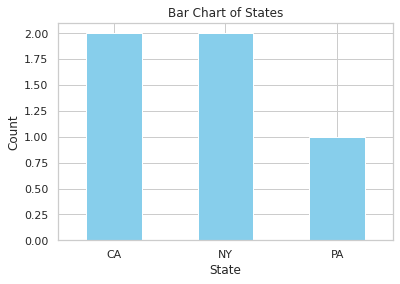

In [217]:
state_counts = top_5_cagr["State"].value_counts()

# Plot the bar chart
state_counts.plot(kind='bar', rot=0, color='skyblue')
plt.xlabel('State')
plt.ylabel('Count')
plt.title('Bar Chart of States')
plt.show()

Our best zipcodes are found in only three states.           
There are two zipcodes from both CA and NY while PA has one zip code. 

We can plot the time series plot of the best    5 zipcodes. 

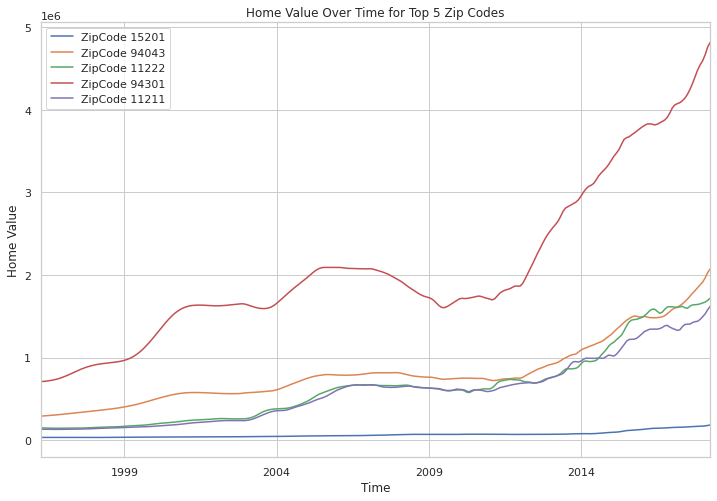

time
1996-04-01     133200.0
1996-05-01     132900.0
1996-06-01     132500.0
1996-07-01     132200.0
1996-08-01     131800.0
                ...    
2017-12-01    1463100.0
2018-01-01    1496100.0
2018-02-01    1531100.0
2018-03-01    1581900.0
2018-04-01    1623700.0
Name: value, Length: 265, dtype: float64

In [218]:
bet_5_zipcodes_list = top_5_cagr["ZipCode"].unique()
plt.figure(figsize=(12, 8))

for zipcode in bet_5_zipcodes_list:
    time_data = bet_5_zipcodes_df[bet_5_zipcodes_df["ZipCode"] == zipcode]["value"]
    time_data.plot(label=f'ZipCode {zipcode}')
time_data
plt.title('Home Value Over Time for Top 5 Zip Codes')
plt.xlabel('Time')
plt.ylabel('Home Value')
plt.legend()
plt.show()
time_data

What are the  10 year ROI and the CAGR for the best 5 zipcodes ?
Let's plot the ROI against the CAGR for the best 5 zipcodes.

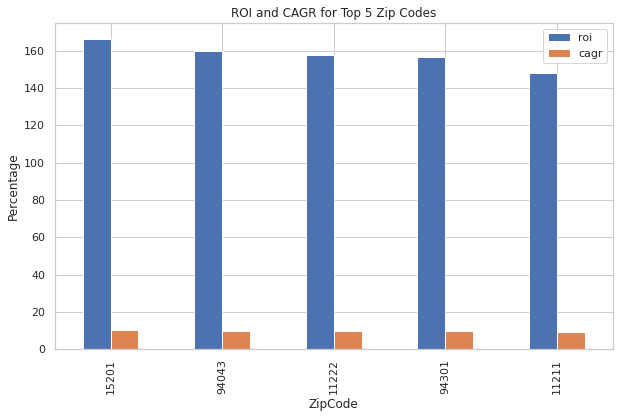

In [219]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot both ROI and CAGR on the same axes
top_5_cagr.plot.bar(x="ZipCode", y=["roi", "cagr"], ax=ax)

# Set labels and title
ax.set_xlabel('ZipCode')
ax.set_ylabel('Percentage')
ax.set_title('ROI and CAGR for Top 5 Zip Codes')

# Show the plot
plt.show()

The property's ROI is significantly high compared to the CAGR. 


ROI as a measure of percentage increase of a property's value compared to the initial investment value, increases greatly compared to the CAGR, the average annual growth rate over a specified period, which provides a smoothed average growth rate over a specific time period, which may give a more stable representation of the property's overall performance.    

#### Time Series Histogram Plots


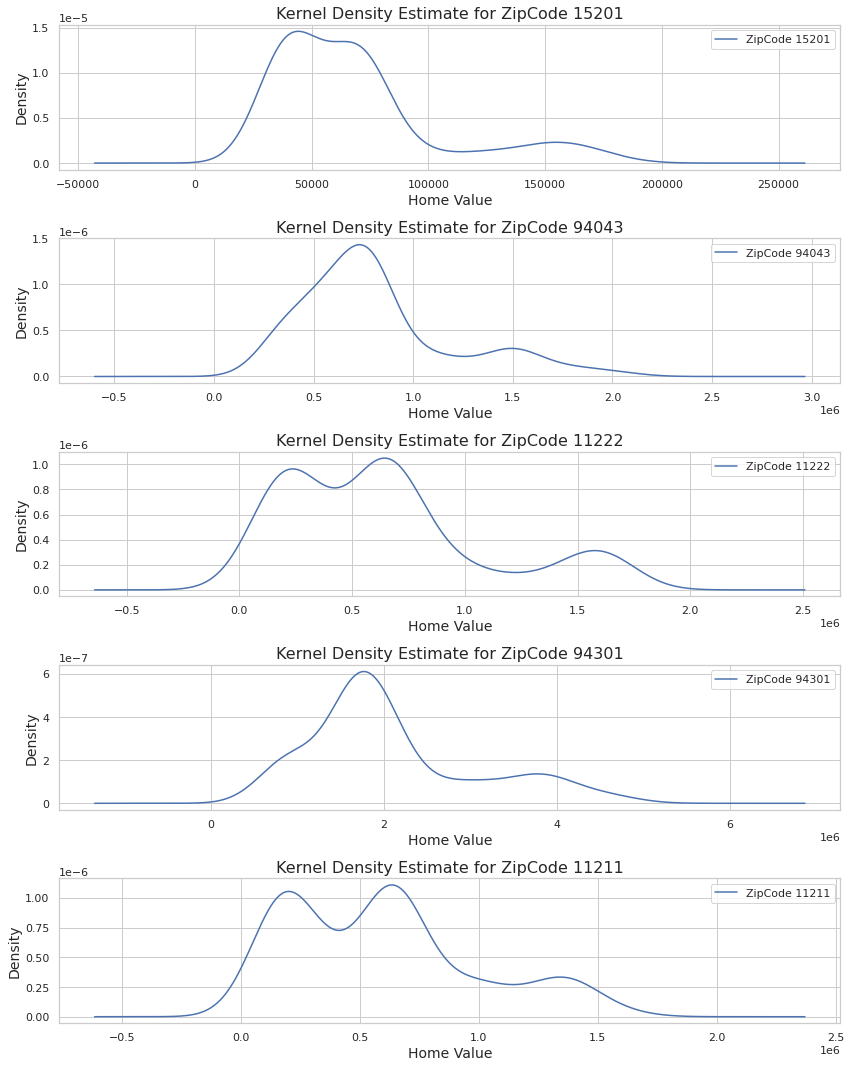

In [220]:

# Set the style to seaborn for better aesthetics
sns.set(style="whitegrid")

# Create subplots for each ZipCode
fig, axes = plt.subplots(nrows=5, figsize=(12, 15))

# Iterate over each ZipCode
for i, zipcode in enumerate(bet_5_zipcodes_list):
    time_data = bet_5_zipcodes_df[bet_5_zipcodes_df["ZipCode"] == zipcode]["value"]
    
    # Plot Kernel Density Estimate (KDE) for each ZipCode
    time_data.plot(kind="kde", label=f'ZipCode {zipcode}', ax=axes[i])
    
    # Set title, labels, and legend for each subplot
    axes[i].set_title(f'Kernel Density Estimate for ZipCode {zipcode}', fontsize=16)
    axes[i].set_xlabel('Home Value', fontsize=14)
    axes[i].set_ylabel('Density', fontsize=14)
    axes[i].legend(loc='upper right')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()



None of these are normally distributed.
We have skewed distribution and bimodal distributions. 

#### Testing for Trends

The time series plot above shows signs of a linear trend. 
Linear trends defy the stationarity assumption assumed by most time series models.            
We need to test for the trends using Rolling statistics.   

We can plot the moving average and moving variance and see if it varies over time. 

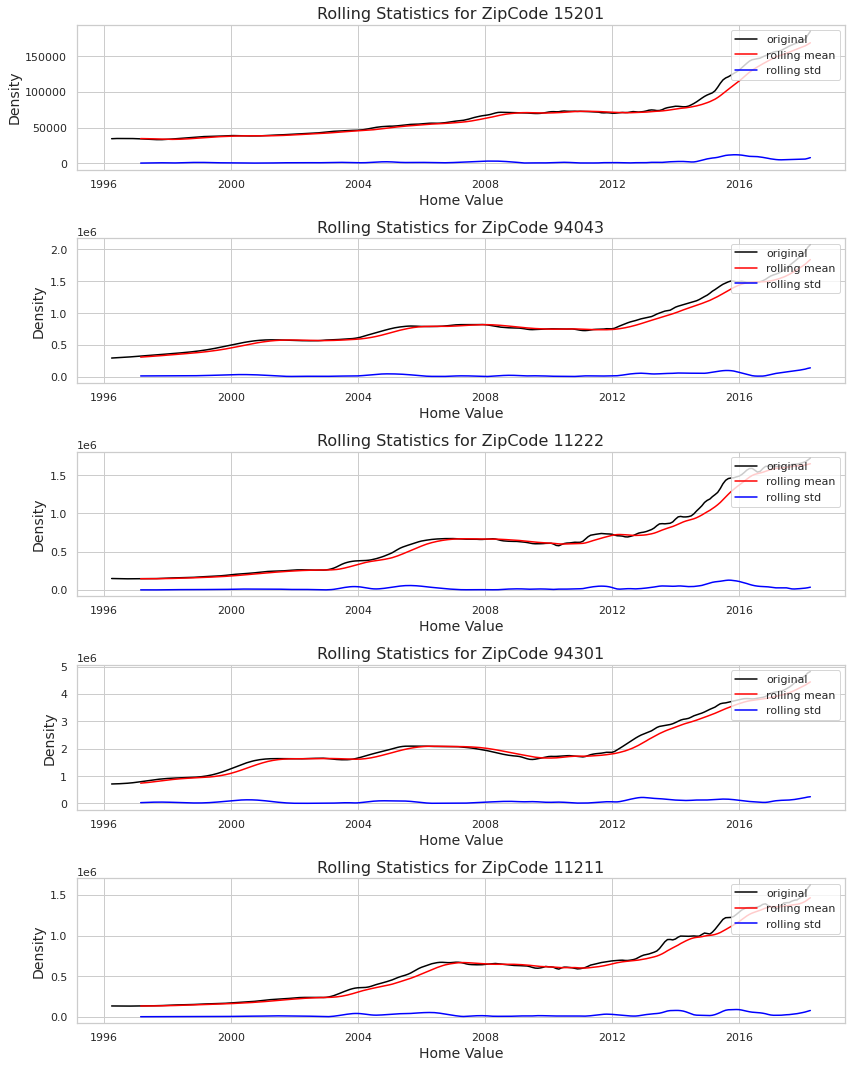

In [221]:
sns.set(style="whitegrid")

# Create subplots for each ZipCode
fig, axes = plt.subplots(nrows=5, figsize=(12, 15))

# Iterate over each ZipCode
for i, zipcode in enumerate(bet_5_zipcodes_list):
    time_data = bet_5_zipcodes_df[bet_5_zipcodes_df["ZipCode"] == zipcode]["value"]
    rolling_mean = time_data.rolling(window=12,center=False).mean()
    rolling_std = time_data.rolling(window=12,center=False).std()
    
    # Plot the rolling statistics for each ZipCode
    axes[i].plot(time_data, color="black", label="original")
    axes[i].plot(rolling_mean, color="red", label="rolling mean")
    axes[i].plot(rolling_std, color="blue", label="rolling std")
    
    # Set title, labels, and legend for each subplot
    axes[i].set_title(f'Rolling Statistics for ZipCode {zipcode}', fontsize=16)
    axes[i].set_xlabel('Home Value', fontsize=14)
    axes[i].set_ylabel('Density', fontsize=14)
    axes[i].legend(loc='upper right')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

Though the variation in standard deviation is small, the mean is increasing with time and thus, this is not a stationary series. 

##### Removing the Trend.


We will try and make our time series data as stationary as possible. 


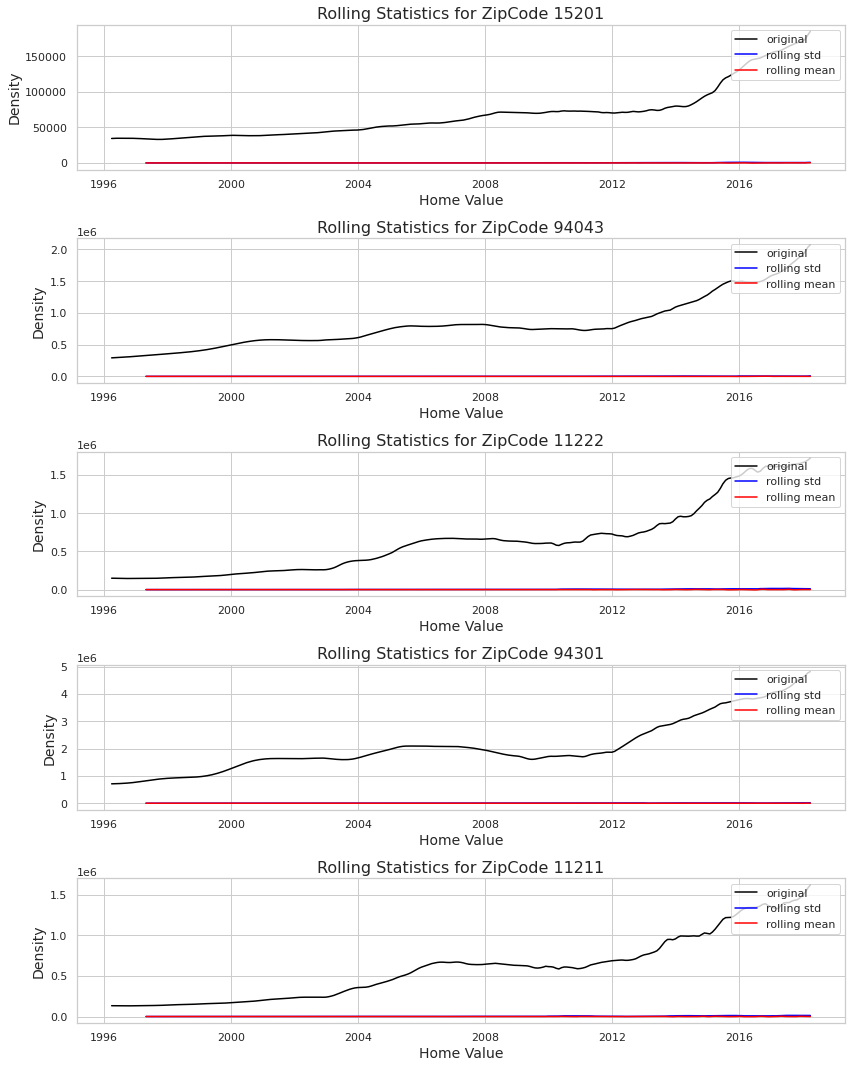

In [222]:
fig, axes = plt.subplots(nrows=5, figsize=(12, 15))

differenced_df = pd.DataFrame()
for i, zipcode in enumerate(bet_5_zipcodes_list):
    # select the home value column
    time_data = bet_5_zipcodes_df[bet_5_zipcodes_df["ZipCode"] == zipcode]["value"]

    data_less_em = time_data - time_data.ewm(halflife=2).mean()
    # decomposition = seasonal_decompose(data_less_em, model="additive")
    # trend = decomposition.trend
    # seasonal = decomposition.seasonal
    # residual = decomposition.resid
    # decomposed_data = residual
    # decomposed_data.dropna(inplace=True)
    # differenced_df[zipcode] = decomposed_data
    differenced_data = data_less_em.diff(periods=1).diff(periods=1).dropna()
    differenced_df[zipcode] = differenced_data
    # decomposition = seasonal_decompose(differenced_data, model="additive")
    # trend = decomposition.trend
    # seasonal = decomposition.seasonal
    # residual = decomposition.resid
    # decomposed_data = residual
    # decomposed_data.dropna(inplace=True)
    # differenced_df[zipcode] = decomposed_data
 
    # calculate the rolling statistics
    rolling_mean = differenced_data.rolling(window=12,center=False).mean()
    rolling_std = differenced_data.rolling(window=12,center=False).std()

    # Plot different times series  for each ZipCode
    axes[i].plot(time_data, color="black", label="original")
    axes[i].plot(rolling_std, color="blue", label="rolling std")
    axes[i].plot(rolling_mean, color="red", label="rolling mean")
    
    # Set title, labels, and legend for each subplot
    axes[i].set_title(f'Rolling Statistics for ZipCode {zipcode}', fontsize=16)
    axes[i].set_xlabel('Home Value', fontsize=14)
    axes[i].set_ylabel('Density', fontsize=14)
    axes[i].legend(loc='upper right')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()



### AutoCorrelation Function
The autocorrelation function is a function that represents autocorrelation of a time series as a function of the time lag. 
ACF indicates how similar a value is within a given time series and the previous value. (OR) It measures the degree of the similarity between a given time series and the lagged version of that time series at the various intervals we observed

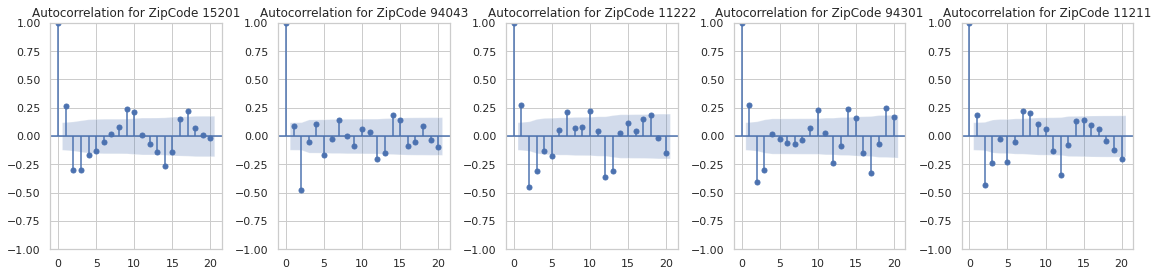

In [223]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming differenced_df is your DataFrame
fig, ax = plt.subplots(ncols=5, figsize=(16, 4))

# Iterate through each column and plot autocorrelation
for i, zipcode in enumerate(differenced_df.columns):
    plot_acf(differenced_df[zipcode], ax=ax[i], lags=20)
    ax[i].set_title(f'Autocorrelation for ZipCode {zipcode}')

plt.tight_layout()
plt.show()



### Partial Autocorrelation Function
Partial Autocorrelation Function (or PACF) gives the partial correlation of a time series with its own lagged values, controlling for the values of the time series at all shorter lags (unlike the autocorrelation function, which does not control for other lags).

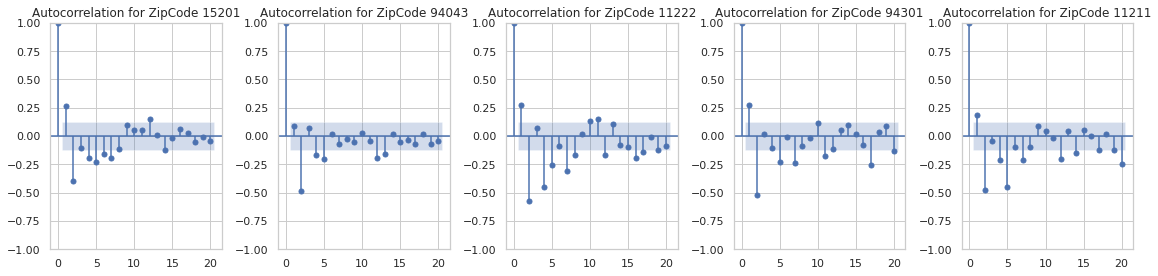

In [224]:
fig, ax = plt.subplots(ncols=5, figsize=(16, 4))

# Iterate through each column and plot autocorrelation
for i, zipcode in enumerate(differenced_df.columns):
    plot_pacf(differenced_df[zipcode], ax=ax[i], lags=20)
    ax[i].set_title(f'Autocorrelation for ZipCode {zipcode}')

plt.tight_layout()
plt.show()


In [225]:
# Calculate the index to split the DataFrame
train_size = int(len(differenced_df) * 0.8)

# Split the DataFrame into training and test sets
train_set = differenced_df.iloc[:train_size]
test_set = differenced_df.iloc[train_size:]

# Print the lengths of the training and test sets
print(f"Training set length: {len(train_set)}")
print(f"Test set length: {len(test_set)}")

Training set length: 210
Test set length: 53


# MODELLING

### AUTOREGRESSIVE MODEL

In [226]:
predicted_data = pd.DataFrame()

for zipcode in train_set.columns:
    # Assuming you want to use ARMA model
    order_tuple = (2, 1, 1)  # Replace with your order values

    # Fit ARMA model
    model_arma = ARIMA(train_set[zipcode], order=order_tuple)
    res_arma = model_arma.fit()

    # Obtain predictions for the test set
    predicted_values = res_arma.predict(start=test_set.index[0], end=test_set.index[-1])

    # Store the predicted values in the DataFrame
    predicted_data[zipcode] = predicted_values

    print(res_arma.summary())


                               SARIMAX Results                                
Dep. Variable:                  15201   No. Observations:                  210
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -1358.948
Date:                Thu, 18 Jan 2024   AIC                           2725.897
Time:                        23:08:05   BIC                           2739.266
Sample:                    06-01-1996   HQIC                          2731.302
                         - 11-01-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2514      0.047      5.360      0.000       0.159       0.343
ar.L2         -0.4963      0.058     -8.561      0.000      -0.610      -0.383
ma.L1         -0.9998      2.786     -0.359      0.7

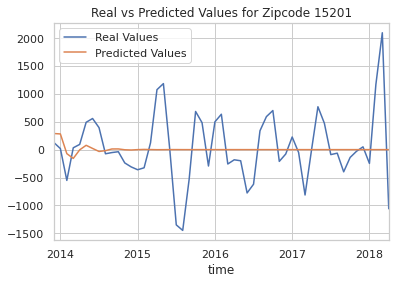

Mean Squared Error (MSE): 621.5932648515366


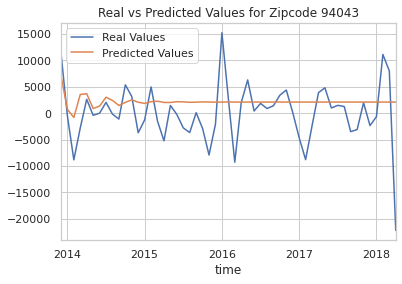

Mean Squared Error (MSE): 5842.791700958592


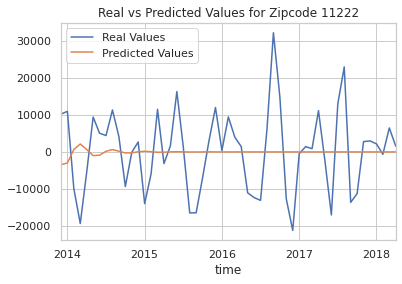

Mean Squared Error (MSE): 11272.895132182806


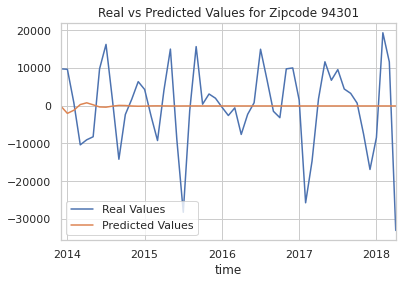

Mean Squared Error (MSE): 10996.516627517576


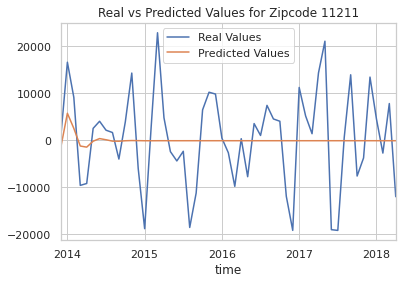

Mean Squared Error (MSE): 9953.08705651314


In [227]:

for zipcode in differenced_df.columns:
    real_values = test_set[zipcode]
    predicted_values = predicted_data[zipcode]
    real_values.plot()
    predicted_values.plot()
    plt.title(f"Real vs Predicted Values for Zipcode {zipcode}")
    plt.legend(["Real Values", "Predicted Values"])
    plt.show()
    rmse = sqrt(mean_squared_error(real_values, predicted_values))

    print(f"Mean Squared Error (MSE): {rmse}")


## Auto Arima

In [228]:
all_train_dates, all_test_dates = [], []
all_train_values, all_test_values = [], []
all_predictions = []
all_forecasts = []

results_list = []

for zipcode in differenced_df.columns:
    data = differenced_df[zipcode]

    # Split the data 
    train_size = int(len(data) * 0.8)
    train, test = data[:train_size], data[train_size:]

    # accumulate values for each fold
    zip_train_dates, zip_test_dates = data.index[:train_size], data.index[train_size:]
    zip_train_values, zip_test_values = train, test

    all_train_dates.extend(zip_train_dates)
    all_test_dates.extend(zip_test_dates)
    all_train_values.extend(zip_train_values)
    all_test_values.extend(zip_test_values)

    # Use auto_arima for automatic ARIMA order selection
    arima_model = auto_arima(train, seasonal=True,suppress_warnings=True, stepwise=True)
    
    # Obtain predictions for the observed period
    predicted_values = arima_model.predict(n_periods=len(test))
    all_predictions.append(pd.Series(predicted_values, index=zip_test_dates))

    # # Obtain forecasts for the next ten years
    forecast_values = arima_model.predict(n_periods=120)
    all_forecasts.append(pd.Series(forecast_values, index=pd.date_range(start="2018-04-01", periods=120, freq="M")))

    print(arima_model.summary())
    print(forecast_values)

# Concatenate all individual predictions for ensemble
all_prediction_df = pd.concat(all_predictions, axis=1)
all_prediction_df.columns=[15201,94043,	11222,	94301,	11211]



                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  210
Model:               SARIMAX(5, 0, 0)   Log Likelihood               -1341.806
Date:                Thu, 18 Jan 2024   AIC                           2695.611
Time:                        23:08:08   BIC                           2715.694
Sample:                    06-01-1996   HQIC                          2703.730
                         - 11-01-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0346      0.051      0.682      0.495      -0.065       0.134
ar.L2         -0.5462      0.056     -9.795      0.000      -0.655      -0.437
ar.L3         -0.4054      0.063     -6.404      0.0

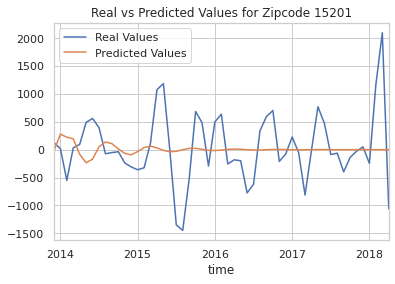

Mean Squared Error (MSE): 633.2287691338327


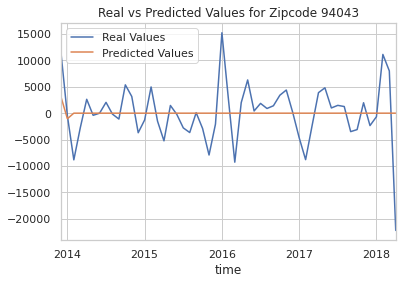

Mean Squared Error (MSE): 5567.252300726133


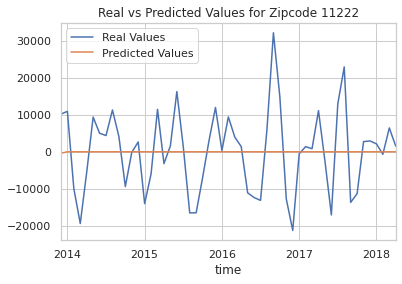

Mean Squared Error (MSE): 11044.35031794276


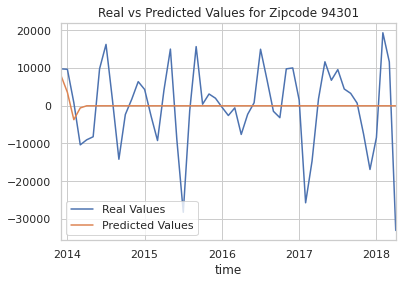

Mean Squared Error (MSE): 10789.985296397595


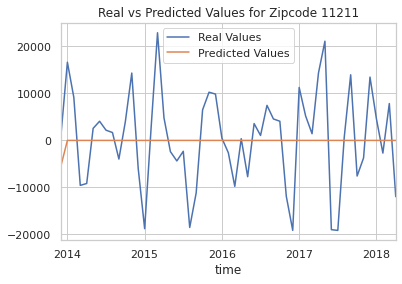

Mean Squared Error (MSE): 10219.51700395962


In [229]:
for zipcode in differenced_df.columns:
    real_values = differenced_df[all_test_dates[0]:][zipcode]
    predicted_values = all_prediction_df[zipcode]
    real_values.plot()
    predicted_values.plot()
    plt.title(f"Real vs Predicted Values for Zipcode {zipcode}")
    plt.legend(["Real Values", "Predicted Values"])
    plt.show()
    rmse = sqrt(mean_squared_error(real_values, predicted_values))

    print(f"Mean Squared Error (MSE): {rmse}")

### FACEBOOK PROPHET

In [230]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

# Assuming your data is stored in a DataFrame named 'df'
# If not, replace 'df' with the actual name of your DataFrame

predicted = pd.DataFrame()
for zipcode in differenced_df.columns:
    # Extract data for the specific zipcode
    data = train_set[[zipcode]].reset_index()
    data.columns = ['ds', 'y']

    # Initialize and fit the Prophet model
    prophet_model = Prophet()
    prophet_model.fit(data)

    # Make a dataframe containing future dates for prediction
    predict_df = prophet_model.make_future_dataframe(periods=len(test_set), freq='M', include_history=False)

    # Obtain predictions for the observed period
    predicted_values = prophet_model.predict(predict_df)
    predicted[zipcode] = predicted_values["yhat"]
    predicted["time"] = predicted_values["ds"]

23:08:15 - cmdstanpy - INFO - Chain [1] start processing


23:08:15 - cmdstanpy - INFO - Chain [1] done processing
23:08:15 - cmdstanpy - INFO - Chain [1] start processing
23:08:15 - cmdstanpy - INFO - Chain [1] done processing
23:08:15 - cmdstanpy - INFO - Chain [1] start processing
23:08:15 - cmdstanpy - INFO - Chain [1] done processing
23:08:15 - cmdstanpy - INFO - Chain [1] start processing
23:08:16 - cmdstanpy - INFO - Chain [1] done processing
23:08:16 - cmdstanpy - INFO - Chain [1] start processing
23:08:16 - cmdstanpy - INFO - Chain [1] done processing


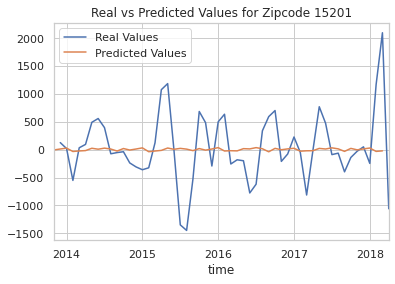

Mean Squared Error (MSE): 625.6568912219711


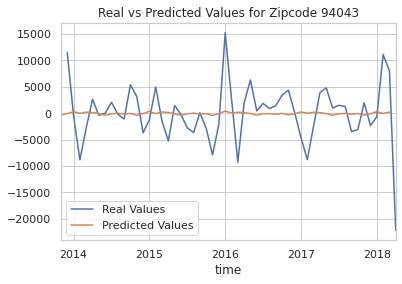

Mean Squared Error (MSE): 5689.319310893201


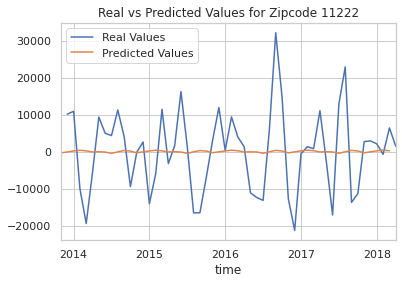

Mean Squared Error (MSE): 11065.254407479682


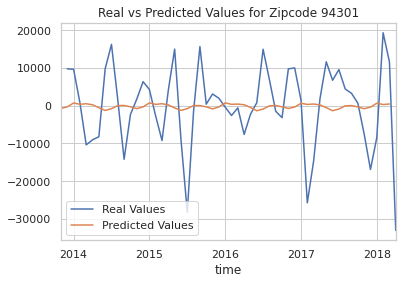

Mean Squared Error (MSE): 11059.6990327877


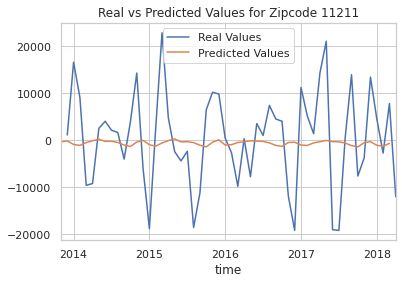

Mean Squared Error (MSE): 10306.4017169808


In [231]:
all_prediction_df = predicted.set_index("time")
for zipcode in differenced_df.columns:
    real_values = test_set[zipcode]
    predicted_values = all_prediction_df[zipcode]
    real_values.plot()
    predicted_values.plot()
    plt.title(f"Real vs Predicted Values for Zipcode {zipcode}")
    plt.legend(["Real Values", "Predicted Values"])
    plt.show()
    rmse = sqrt(mean_squared_error(real_values, predicted_values))

    print(f"Mean Squared Error (MSE): {rmse}")

In [232]:
predicted = pd.DataFrame()
for zipcode in differenced_df.columns:
    time_data = differenced_df[:"2008-04-1"][zipcode]
    fitted_model = ExponentialSmoothing(time_data,trend='mul',seasonal=None).fit()
    test_predictions = fitted_model.forecast(120)
    predicted[zipcode] = test_predictions

ValueError: endog must be strictly positive when usingmultiplicative trend or seasonal components.

In [ ]:
for zipcode in differenced_df.columns:
    real_values = differenced_df["2008-05-01":][zipcode]
    predicted_values = predicted[zipcode]
    real_values.plot()
    predicted_values.plot()
    plt.title(f"Real vs Predicted Values for Zipcode {zipcode}")
    plt.legend(["Real Values", "Predicted Values"])
    plt.show()
    rmse = sqrt(mean_squared_error(real_values, predicted_values))

    print(f"Mean Squared Error (MSE): {rmse}")


KeyError: 15201

In [ ]:
# Extract the time series data for a specific zipcode
zipcode_data = df['your_zipcode_column_name']

# Split the data into training and testing sets
train, test = train_test_split(zipcode_data, train_size=0.8)

# Set the parameter search range
p_range = d_range = q_range = range(0, 3)  # Adjust the range as needed

best_model = None
best_mse = np.inf

# Perform grid search for SARIMA parameters
for p in p_range:
    for d in d_range:
        for q in q_range:
            try:
                # Fit the SARIMA model
                model = pm.auto_arima(train, seasonal=True, m=12, stepwise=True, suppress_warnings=True,
                                      start_p=p, d=d, start_q=q, max_order=None)
                
                # Make predictions on the test set
                forecast, conf_int = model.predict(test.shape[0], return_conf_int=True)
                
                # Calculate Mean Squared Error (MSE)
                mse = mean_squared_error(test, forecast)
                
                # Update the best model if the current one has a lower MSE
                if mse < best_mse:
                    best_mse = mse
                    best_model = model
                    
                print(f'SARIMA({p},{d},{q}) - MSE: {mse:.2f}')
            except Exception as e:
                print(f'Error for SARIMA({p},{d},{q}): {e}')

# Display the best model summary
print("Best Model Summary:")
print(best_model.summary())
for zip_code in differenced_df

SyntaxError: invalid syntax (<ipython-input-34-40a974579a43>, line 40)